### Data Loading / Cleaning

In [1]:
import pandas as pd
import seaborn as sns
pd.options.display.max_columns = None

pd.set_option('mode.chained_assignment', None)

df = pd.read_csv("./data/anime.csv")

Our dataset contains information regarding various animes (Japanese animations) and their ratings on a popular anime tracking website (myanimelist.net). Some examples of features in the dataset include: Score (1-10 rating given to an anime), Genres, Episodes, etc.

Target:
 - Score (regression)

Features:
 - Genres
 - Type
 - Episodes
 - Studio
 - Rating
 - Source
 - Duration
 

In [2]:
filtered_df = df[(df.Score != "Unknown") & (df.Episodes != "Unknown") & (df.Duration != 'Unknown')]

filtered_df['Score'] = filtered_df['Score'].astype(float)
filtered_df['Episodes'] = filtered_df['Episodes'].astype(int)

### Data Exploration

In [3]:
filtered_df.describe()

,MAL_ID,Score,Episodes,Popularity,Members,Favorites,Watching,Completed,On-Hold,Dropped,Plan to Watch
count,12296.000000,12296.000000,12296.000000,12296.000000,1.229600e+04,12296.000000,12296.000000,1.229600e+04,12296.000000,12296.000000,12296.000000
mean,17225.452342,6.511083,11.334418,6434.816607,4.878342e+04,638.940306,3048.951285,3.152893e+04,1330.480563,1637.857433,11237.200065
std,14403.809644,0.887740,42.827926,3853.011858,1.467946e+05,4706.775451,14398.877663,1.073935e+05,4704.337313,5356.742450,27378.358507
min,1.000000,1.850000,1.000000,1.000000,1.720000e+02,0.000000,0.000000,0.000000e+00,0.000000,0.000000,12.000000
25%,3542.750000,5.930000,1.000000,3124.000000,1.489000e+03,2.000000,53.000000,6.580000e+02,33.000000,61.000000,513.750000
50%,11790.000000,6.520000,2.000000,6316.500000,5.342500e+03,10.000000,216.000000,2.736500e+03,134.000000,144.000000,1737.000000
75%,32401.250000,7.140000,12.000000,9585.000000,2.749125e+04,73.000000,1015.000000,1.529725e+04,567.250000,551.000000,7607.250000
max,48456.000000,9.190000,1818.000000,15374.000000,2.589552e+06,183914.000000,566239.000000,2.182587e+06,130961.000000,174710.000000,425531.000000


<AxesSubplot:xlabel='Score', ylabel='Count'>

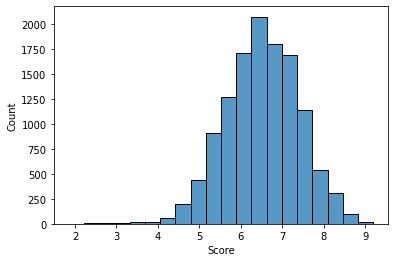

In [4]:
# Let's look at the distribution of scores
sns.histplot(filtered_df['Score'], bins=20)

In [5]:
# We decided to use this total_duration column while keeping the episodes column
# because we want to distinguish between something like a movie, which has a long duration
# but only one "episode" versus an anime with many episodes of shorter duration.
def get_total_duration(X):
    total_durations = []

    for i in range(len(X)):
        row = X.iloc[i]
        dur = row['Duration']
        dur = dur.split(" ")
        minutes = 0;
        if 'hr.' in dur:
            minutes = 60 * int(dur[dur.index('hr.') - 1])
        if 'min.' in dur:
            minutes += int(dur[dur.index('min.') - 1])
        total_durations.append(minutes * row['Episodes'])
    return total_durations

filtered_df['Total_Durations'] = get_total_duration(filtered_df)

<AxesSubplot:title={'center':'Score'}, xlabel='Source'>

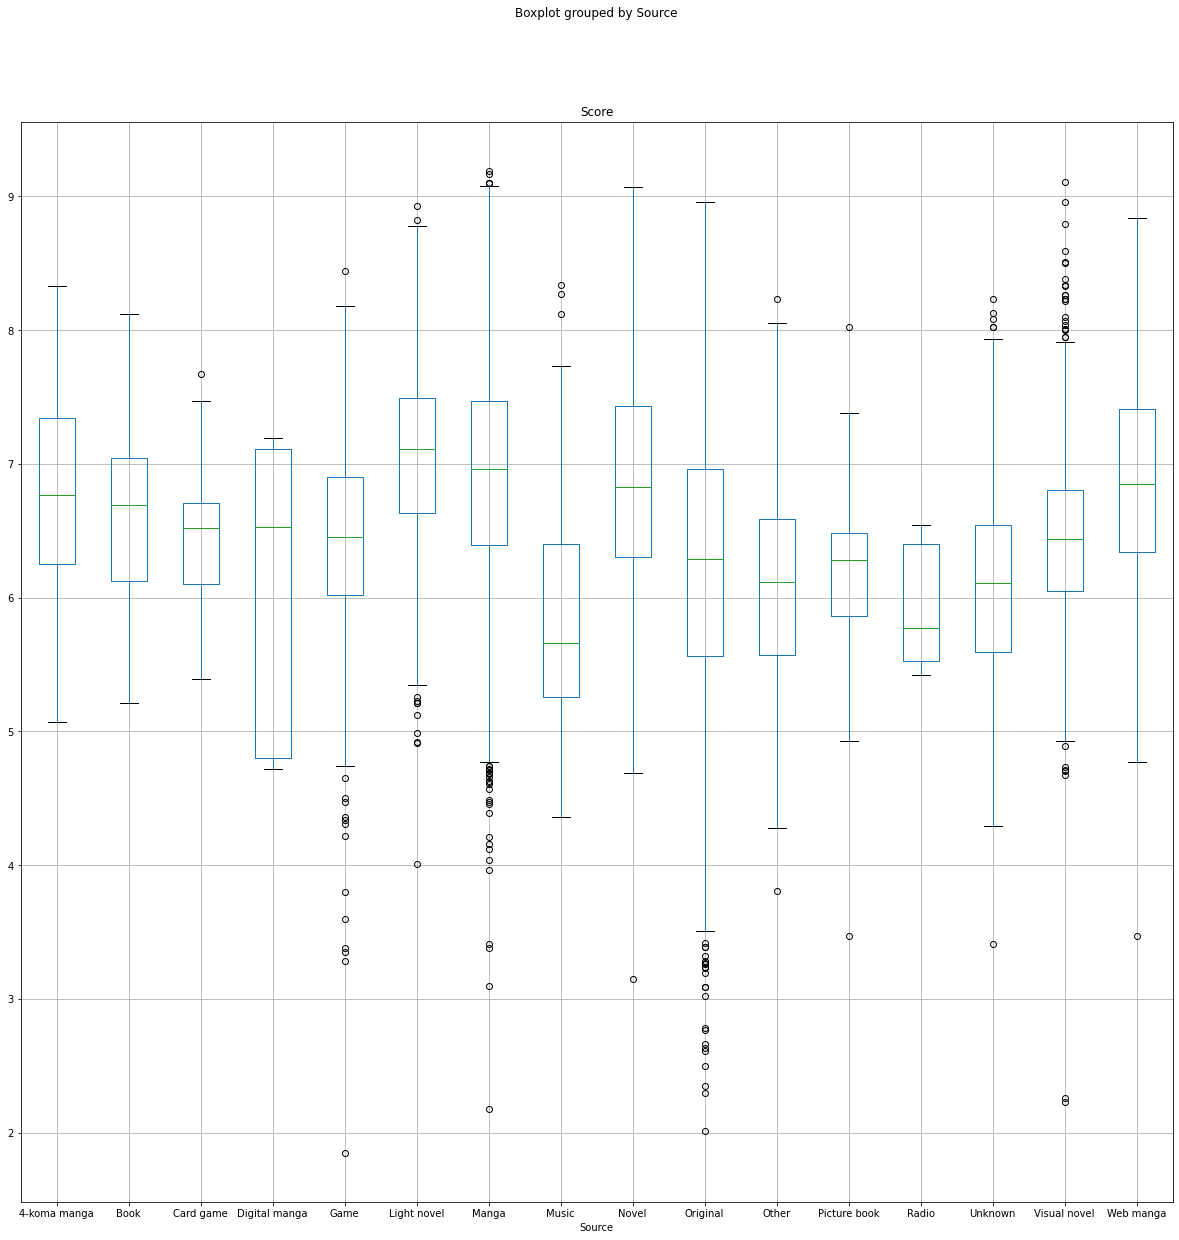

In [6]:
filtered_df.boxplot(column="Score", by="Source", figsize=(20, 20))

<AxesSubplot:xlabel='num_studios', ylabel='Score'>

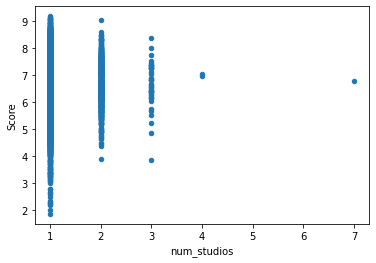

In [7]:
# We had the idea that more studios working on an anime would increase its quality and therefore its chance of success
# However, after plotting the data out, it seems like that's not the case as there is no significant positive correlation

plot_df = pd.DataFrame()
plot_df["Score"] = filtered_df['Score']
plot_df['num_studios'] = filtered_df['Studios'].str.count(",") + 1

plot_df.plot.scatter(x="num_studios", y="Score")

In [8]:
# Notice how, regardless of the number of studios that worked on the anime,
# there doesn't seem to be a large difference in score

plot_df.groupby("num_studios")['Score'].mean().sort_values()

num_studios
1    6.501715
3    6.640952
2    6.677110
7    6.790000
4    7.010000
Name: Score, dtype: float64

In [9]:
# The correlation is only 0.045, and since it is so low, we decided against using 
# the number of studios as a feature. Since the data is not normally distributed, 
# we had to use the spearman's correlation test.
plot_df.corr('spearman')

,Score,num_studios
Score,1.000000,0.045071
num_studios,0.045071,1.000000


As you can see in the boxplot above, there seems to be a pretty solid correlation between the source and the rating

The sources with the best average rating seem to be:
 - Light novel
 - Manga
 - Novel

On the other hand, the sources with the lowest average rating seem to be:
 - Music
 - Radio

In [10]:
filtered_df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1',
       'Total_Durations'],
      dtype='object')

### Feature Engineering

In [11]:
def top_x_studios(size, filtered_df):
    '''
    Returns a pd.Series where True represents if any of the studios in the Studio column are in top size studios.
    '''
    top_studios_combined = filtered_df.sort_values(by="Score", ascending=False)['Studios'][:size].values
    top_studios_set = set()
    studio_top_x_list = []

    for studio in top_studios_combined:
        studios = [i.strip() for i in studio.split(",")]

        for i in studios:
            top_studios_set.add(i)
    
    for idx in range(len(filtered_df)):
        row = filtered_df.iloc[idx]
        row_studios = [i.strip() for i in row["Studios"].split(",")]
        
        in_top_x = any([studio in top_studios_set for studio in row_studios])
        studio_top_x_list.append(in_top_x)

    return studio_top_x_list, top_studios_set

In [12]:
filtered_df['from_top_10_studios'],_ = top_x_studios(10,filtered_df)
filtered_df['from_top_25_studios'],_ = top_x_studios(25, filtered_df)
filtered_df['from_top_50_studios'],_ = top_x_studios(50, filtered_df)
filtered_df['from_top_75_studios'],_ = top_x_studios(75, filtered_df)
filtered_df['from_top_100_studios'],_ = top_x_studios(100, filtered_df)

In [13]:
# Choose the feautures we're going to use
X = filtered_df[["Genres", "Type", "Episodes", "Studios", "from_top_10_studios", "from_top_25_studios", "from_top_50_studios", "from_top_75_studios", "from_top_100_studios","Rating", "Source", "Duration", "Score"]]
y = filtered_df['Score']

X['Episodes'] = X['Episodes'].astype("int")
y = y.astype("float")

# Standardize y values to account for skewed distribution
# Standard deviation of 1, mean of 0
y_mean, y_std = y.mean(), y.std()

y = (y - y_mean) / y_std

#### One-hot encoding the genres

In [14]:
genres = set()
genre_list = X['Genres'].values

for anime_genres in genre_list:
    g = [i.strip() for i in anime_genres.split(",")]
    
    genres.update(g)

genre_names = list(genres)
genre_dict = {val : idx for idx, val in enumerate(genre_names)}

genre_one_hots = []
# Iterate through all the rows of the dataset
# One hot encode that row's genres
# append the one-hot encoded genres to the genre_one_hot list
# repeat for all rows
# convert genre_one_hot into a dataframe
# stack next to each other

for anime_genres in genre_list:
    g = [i.strip() for i in anime_genres.split(",")]
    one_hot = [0 for i in range(len(genres))]

    for i in g:
        one_hot[genre_dict[i]] = 1
    
    genre_one_hots.append(one_hot)

genre_one_hot_df = pd.DataFrame(genre_one_hots, columns=["is_" + name for name in genre_names])

In [15]:
X = pd.concat([X.reset_index().drop(columns=["index"]), genre_one_hot_df], axis=1)

In [16]:
# Drop the original column for genres
X = X.drop(columns=["Genres"])

#### Engineering a total_duration column which represents the number of episodes * length of an episode

In [17]:
X['Total_Durations'] = get_total_duration(X)
X = X.drop('Duration', axis = 1)

#### One-hot encoding type, rating, and source

In [18]:
type_df = pd.get_dummies(X['Type'])
rating_df = pd.get_dummies(X['Rating'])
source_df = pd.get_dummies(X['Source'])

In [19]:
type_df.columns = ["type_is_" + c for c in type_df.columns]
rating_df.columns = ["rating_is_" + c for c in rating_df.columns]
source_df.columns = ["source_is_" + c for c in source_df.columns]

In [20]:
X = pd.concat([X.reset_index().drop(columns=["index"]), type_df, rating_df, source_df], axis=1)
X = X.drop(columns=["Type", "Rating", "Source"])

### More Data Exploration

In [21]:
a = X.reset_index(drop=True)

In [22]:
a.corr()['Score'].abs().sort_values(ascending=False).head(50)

Score                                       1.000000
from_top_75_studios                         0.321749
from_top_50_studios                         0.316362
type_is_TV                                  0.291843
source_is_Manga                             0.283832
rating_is_G - All Ages                      0.272651
rating_is_PG-13 - Teens 13 or older         0.269717
from_top_25_studios                         0.248648
is_Shounen                                  0.243041
is_Drama                                    0.234382
is_Dementia                                 0.225142
source_is_Unknown                           0.206733
from_top_10_studios                         0.202760
type_is_Music                               0.177736
Total_Durations                             0.174691
source_is_Original                          0.169297
is_Romance                                  0.169207
is_Comedy                                   0.166990
is_Action                                   0.

<AxesSubplot:xlabel='rating_is_G - All Ages', ylabel='Score'>

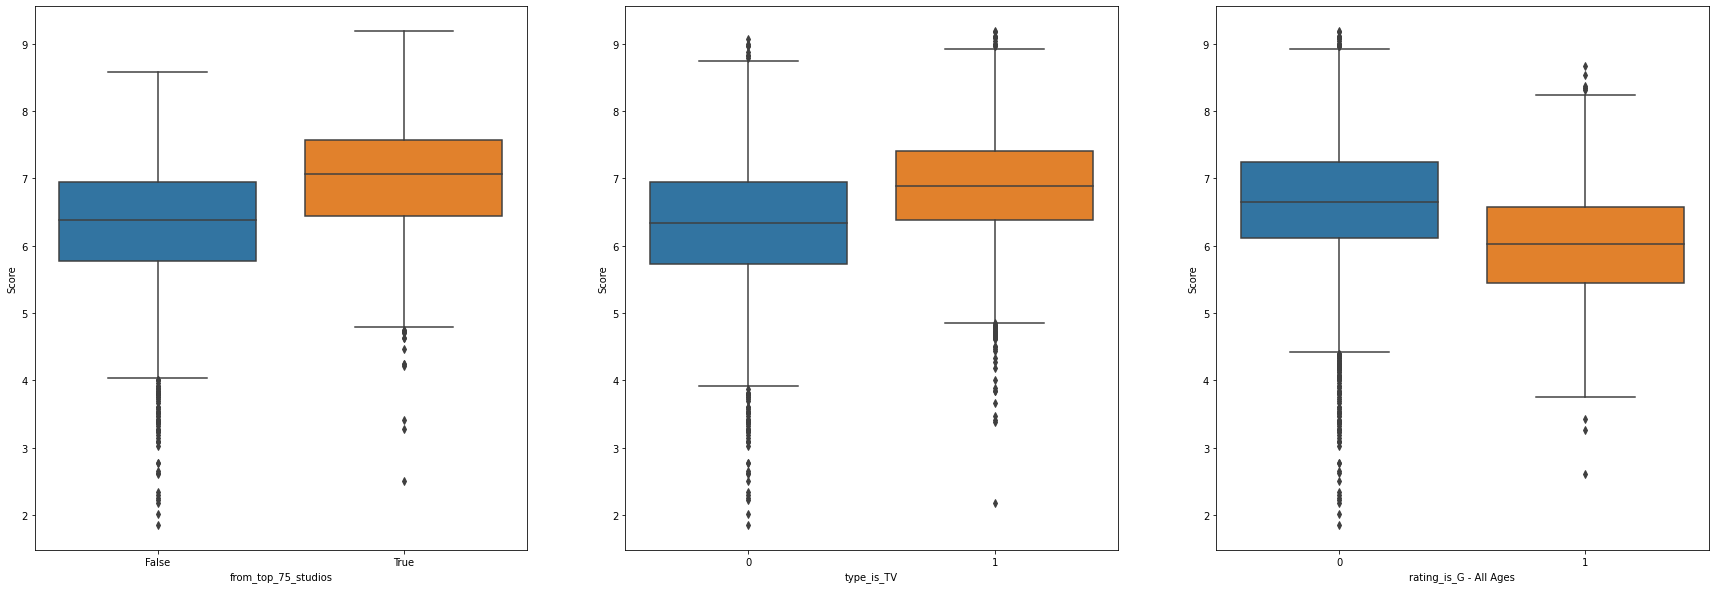

In [23]:
# Based on our above data exploration, we found that the from_top_75_studios variable 
# correlates best with score, and the difference is shown in the boxplot. The scores
# are normalized, so 0 just means the average of all animes. We can also see that
# having a G rating is negatively correlated with score - the average is lower for
# G rated animes than not.
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(30, 10))

plt.subplot(1, 3, 1)
sns.boxplot(data=a, x="from_top_75_studios", y='Score')

plt.subplot(1, 3, 2)
sns.boxplot(data=a, x="type_is_TV", y='Score')

plt.subplot(1, 3, 3)
sns.boxplot(data=a, x="rating_is_G - All Ages", y='Score')

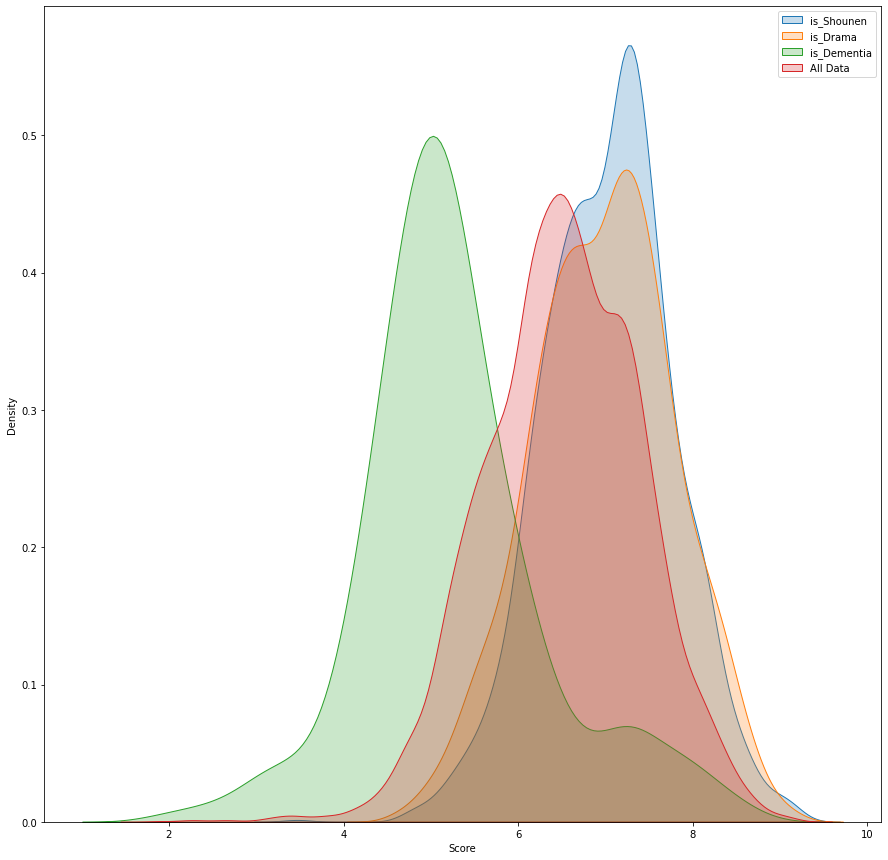

In [24]:
fig, ax = plt.subplots(figsize=(15, 15))

# As we can see in the kernel density estimation plot, some genres, such as 
# is_Shounen (meant for young boys preteen/teen) and is_Drama are positively 
# correlated with score. Meanwhile, some genres, such as is_Dementia, negatively 
# correlate with score.
sns.kdeplot(x="Score", data=a[a['is_Shounen'] == True], ax=ax, label="is_Shounen", fill=True)
sns.kdeplot(x="Score", data=a[a['is_Drama'] == True], ax=ax, label="is_Drama", fill=1)
sns.kdeplot(x="Score", data=a[a['is_Dementia'] == True], ax=ax, label="is_Dementia", fill="True")
sns.kdeplot(x="Score", data=a, ax=ax, label="All Data", fill=[0])
plt.legend()

### Data Analysis / Modeling

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from xgboost import XGBRegressor

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def train_and_results(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)

    preds = clf.predict(X_test)

    return mean_squared_error(y_test, preds), r2_score(y_test, preds)

In [27]:
from sklearn.model_selection import KFold
from tqdm import tqdm


lin_reg_MSE, lin_reg_R2 = 0, 0
random_forest_MSE, random_forest_R2 = 0, 0
svr_MSE, svr_R2 = 0, 0
xgboost_MSE, xgboost_R2 = 0, 0

nsplits = 5

# Split data into 5 folds
kf = KFold(n_splits=nsplits, random_state=True, shuffle=True)
for i, (train_index, test_index) in tqdm(enumerate(kf.split(X))):
    xtrain = X.iloc[train_index]
    xtest = X.iloc[test_index]
    ytrain = y.iloc[train_index]
    ytest = y.iloc[test_index]

    #Recompute the top x studios using train data
    xtrain['from_top_10_studios'],top_10 = top_x_studios(10,xtrain)
    xtrain['from_top_25_studios'],top_25 = top_x_studios(25,xtrain)
    xtrain['from_top_50_studios'],top_50 = top_x_studios(50,xtrain)
    xtrain['from_top_75_studios'],top_75 = top_x_studios(75,xtrain)

    #Apply top n studios to test data
    xtest['from_top_10_studios'] = xtest['Studios'].str.contains("|".join(top_10))
    xtest['from_top_25_studios'] = xtest['Studios'].str.contains("|".join(top_25))
    xtest['from_top_50_studios'] = xtest['Studios'].str.contains("|".join(top_50))
    xtest['from_top_75_studios'] = xtest['Studios'].str.contains("|".join(top_75))

    xtrain = xtrain.drop(columns=['Score', 'Studios'])
    xtest = xtest.drop(columns=['Score', 'Studios'])

    #Initialize models and run them updating mse and r^2 in the process.
    linear_regression = LinearRegression()
    random_forest = RandomForestRegressor()
    svr = SVR(C=1.0, epsilon=0.2)
    xgb = XGBRegressor()

    linear_regression_results = train_and_results(linear_regression, xtrain, ytrain, xtest, ytest)
    lin_reg_MSE += linear_regression_results[0]
    lin_reg_R2 += linear_regression_results[1]

    random_forest_results = train_and_results(random_forest, xtrain, ytrain, xtest, ytest)
    random_forest_MSE += random_forest_results[0]
    random_forest_R2 += random_forest_results[1]

    svr_results = train_and_results(svr, xtrain, ytrain, xtest, ytest)
    svr_MSE += svr_results[0]
    svr_R2 += svr_results[1]

    xgboost_results = train_and_results(xgb, xtrain, ytrain, xtest, ytest)
    xgboost_MSE += xgboost_results[0]
    xgboost_R2 += xgboost_results[1]

5it [02:12, 26.48s/it]


In [28]:
#Print Average Results
print(f"Linear regression: SE = {lin_reg_MSE / nsplits}, R2 = {lin_reg_R2 / nsplits}")
print(f"Random Forest: SE = {random_forest_MSE / nsplits}, R2 = {random_forest_R2 / nsplits}")
print(f"SVR: SE = {svr_MSE / nsplits}, R2 = {svr_R2 / nsplits}")
print(f"XGBoost : SE = {xgboost_MSE / nsplits}, R2 = {xgboost_R2 / nsplits}") 

Linear regression: SE = 0.5718342008532279, R2 = 0.4280161020604102
Random Forest: SE = 0.45136362610366965, R2 = 0.5484746016578701
SVR: SE = 0.7715891281611167, R2 = 0.22813993917213343
XGBoost : SE = 0.43339105814266476, R2 = 0.5663275113968086
